In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown

## Нелинейное уравнение

IV.12.4, вариант д)

![title](eq_var.jpeg)

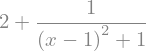

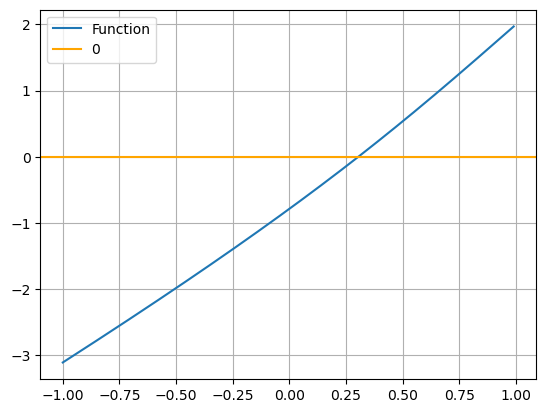

In [14]:
# Prepare sympy
x = sym.Symbol('x')
sym.init_printing()

# Function and it's derivative
sym_func = sym.atan(x - 1) + 2*x
sym_deriv = sym.diff(sym_func, x)
display(sym_func)
display(sym_deriv)
func  = sym.lambdify(x, sym_func,  "numpy")
deriv = sym.lambdify(x, sym_deriv, "numpy")

x = np.arange(-1, 1, 0.01)
plt.plot(x, func(x), label='Function')
plt.axhline(y=0, c='orange', label='0')
plt.grid(True)
plt.legend()

### Метод Ньютона

In [3]:
def solveEqNewton(func, x0, n_iter, precision, left, right):
    assert precision > 0, "Precision must be positive."
    deriv = lambda x, h: (func(x+h) - func(x-h)) / (2*h)
    diff = []
    
    x = x0
    h = np.min([np.abs(x - left), np.abs(x - right)])

    for i in range(n_iter):
        assert left < x and x < right, f"Gone out of bounds on iter {i}. Diffs: {diff}"

        old_x = x
        x = x - func(x) / deriv(x, h)

        d = np.abs(x - old_x)
        diff.append(d)
        if d <= precision:
            break

        h = d

    return x, diff

Root: x = 0.30401360
Reference: x = 0.30401360


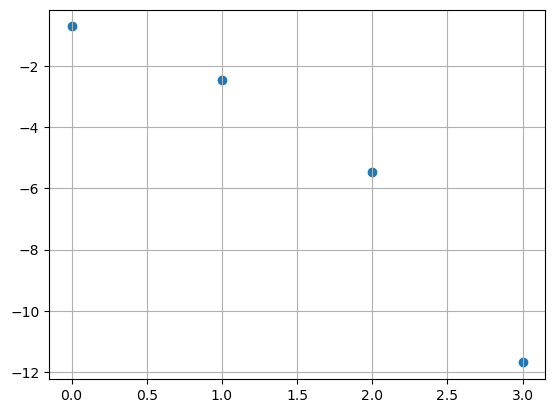

In [15]:
x, diff = solveEqNewton(func, 0.5, 15, 1e-8, -1, 1)
print(f"Root: x = {x:.8f}")

xref = sp.optimize.fsolve(func, 0.5)
print(f"Reference: x = {xref[0]:.8f}")

plt.scatter(range(len(diff)), np.log10(diff))
plt.grid()

### Метод простой итерации

In [5]:
def solveEqFpi(fpi, x0, n_iter, precision, left, right):
    assert precision > 0, "Precision must be positive."
    
    deriv = lambda x, h: (fpi(x+h) - fpi(x-h)) / (2*h)
    h = np.min([np.abs(x0 - left), np.abs(x0 - right)])
    assert np.abs(deriv(x0, h)) < 1, f"FPI method does not converge: {deriv(x0, h)=}"

    x = x0
    diff = []

    for i in range(n_iter):
        assert left < x and x < right, f"Gone out of bounds on iter {i}."
        old_x = x
        x = fpi(x)
        d = np.abs(x - old_x)
        diff.append(d)
        if d < precision:
            break
    

    return x, diff

Root: x = 0.30401360
Reference: x = 0.30401360


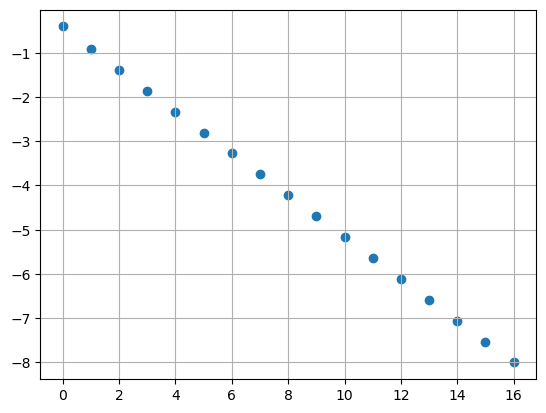

In [6]:
# Prepare sympy
x = sym.Symbol('x')
sym.init_printing()

sym_fpi_func  = -sym.atan(x - 1) / 2
sym_fpi_deriv = sym.diff(sym_fpi_func, x)
fpi_func  = sym.lambdify(x, sym_fpi_func,  "numpy")
fpi_deriv = sym.lambdify(x, sym_fpi_deriv, "numpy")

x, diff = solveEqFpi(fpi_func, 0, 20, 1e-8, -1, 1)
print(f"Root: x = {x:.8f}")

xref = sp.optimize.fsolve(func, 0)
print(f"Reference: x = {xref[0]:.8f}")

plt.scatter(range(len(diff)), np.log10(diff))
plt.grid()    

## Решение нелинейной системы

IV.12.7, вариант д)

![title](sys_var.jpeg)

In [7]:
f = lambda x: np.array([
    x[0]**7 - 5 * x[0]**2 * x[1]**4 + 1510,
    x[1]**3 - 3 * x[0]**4 * x[1] - 105,
])

### Метод Ньютона

In [8]:
def partial(f, x, var_index, h):
    dim = len(x)
    assert var_index < dim, "Index of variable is greater than dimensity."

    vec_h = np.zeros(dim)
    vec_h[var_index] = h

    return (f(x+vec_h) - f(x-vec_h)) / (2*h)

def getJacobi(f, x, h):
    dim = len(f(x))
    assert dim == len(x), "f and x must be of same size."
    J = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            J[i][j] = partial(lambda x: f(x)[i], x, j, h[i])
    
    return J

def solveSystemNewton(f, x0, n_iter, precision, bl, tr):
    assert precision > 0, "Precision must be positive."
    dim = len(f(x0))
    assert len(x0) == dim and len(bl) == dim and len(tr) == dim, "f, x0, bl and tr must be of same size."
    h = [np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)]
    x = x0

    diff = []
    for i in range(n_iter):
        assert np.all(bl < x) and np.all(x < tr), f"Gone out of bounds on iter {i}. Diff: {diff}."
        old_x = x
        x = x - np.matmul(np.linalg.inv(getJacobi(f, x, h)), f(x))
        d = np.abs(x - old_x)
        h = d
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

Localization: 1.5 < x0 = 2 < 2.5, -3.5 < y0 = -3 < -2.5
Solution:  (1.95488, -3.03400)
Reference: (1.95488, -3.03400)
Localization: 0.5 < x0 = 1 < 1.5, 4.5 < y0 = 5 < 5.5
Solution:  (0.75817, 4.78773)
Reference: (0.75817, 4.78773)
Localization: -1.5 < x0 = -1 < -0.5, 4.5 < y0 = 5 < 5.5
Solution:  (-0.75810, 4.78770)
Reference: (-0.75810, 4.78770)
Localization: -3.5 < x0 = -3 < -2.5, -1 < y0 = -0.5 < 0
Solution:  (-2.84448, -0.53542)
Reference: (-2.84448, -0.53542)
Localization: -2.5 < x0 = -2 < -1.5, -3.5 < y0 = -3 < -2.5
Solution:  (-1.96241, -2.91899)
Reference: (-1.96241, -2.91899)


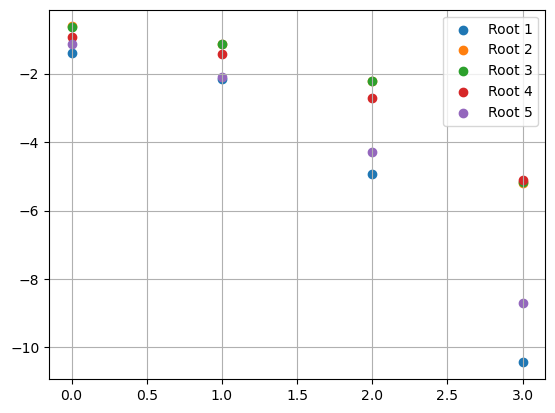

In [9]:
def solve(label, x0, bl, tr):
    print(f"Localization: {bl[0]} < x0 = {x0[0]} < {tr[0]}, {bl[1]} < y0 = {x0[1]} < {tr[1]}")
    x, diff = solveSystemNewton(f, x0, 10, 1e-5, bl, tr)
    print(f"Solution:  ({x[0]:.5f}, {x[1]:.5f})")

    xref = sp.optimize.fsolve(f, x0)
    print(f"Reference: ({xref[0]:.5f}, {xref[1]:.5f})")

    assert np.linalg.norm(xref - x, ord=np.inf) < 1e-5, "Solution and reference differ."

    plt.scatter(range(len(diff)), np.log10(diff), label=label)
    plt.grid(True)
    plt.legend()

solve("Root 1", [     2,    -3], [  1.5,  -3.5], [   2.5, -2.5])
solve("Root 2", [     1,     5], [  0.5,   4.5], [   1.5,  5.5])
solve("Root 3", [    -1,     5], [ -1.5,   4.5], [  -0.5,  5.5])
solve("Root 4", [    -3,  -0.5], [ -3.5,    -1], [  -2.5,    0])
solve("Root 5", [    -2,    -3], [ -2.5,  -3.5], [  -1.5, -2.5])

### Метод простой итерации

In [10]:
def solveSystemFpi(fpi, x0, n_iter, precision, bl, tr):
    assert precision > 0, "Precision must be positive."
    dim = len(fpi(x0))
    assert len(x0) == dim and len(bl) == dim and len(tr) == dim, "f, x0, bl and tr must be of same size."
    h = 1e-3 * np.array([np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)])
    x = x0

    J = getJacobi(fpi, x0, h)
    display(J)
    J_norm = np.linalg.norm(J, ord=np.inf)
    print(J_norm)
    if J_norm > 1 or np.isnan(J_norm):
        print("WARNING: FPI does not converge.")

    diff = []
    for i in range(n_iter):
        assert np.all(bl < x) and np.all(x < tr), f"Gone out of bounds on iter {i}. Diff: {diff}."
        old_x = x
        x = fpi(x)
        d = np.abs(x - old_x)
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

--------------------------------------------------------------------------------
Localization: 0.5 < x0 = 1 < 1.5, 4.5 < y0 = 5 < 5.5


array([[ 0.00161069, -0.27814242],
       [ 0.8220708 ,  0.04110353]])

0.8631743382903068
Solution: (0.75817, 4.78772)
Reference: (0.75817, 4.78773)
--------------------------------------------------------------------------------
Localization: 1.5 < x0 = 2 < 2.5, -3.5 < y0 = -3 < -2.5


array([[0.        , 0.06300832],
       [0.54637906, 0.        ]])

0.5463790550379599
Solution: (1.95488, -3.03400)
Reference: (1.95488, -3.03400)
--------------------------------------------------------------------------------
Localization: -2.5 < x0 = -2 < -1.5, -3.5 < y0 = -3 < -2.5


array([[ 0.        , -0.06300832],
       [-0.95444875,  0.        ]])

0.954448753844872
Solution: (-1.96241, -2.91899)
Reference: (-1.96241, -2.91899)


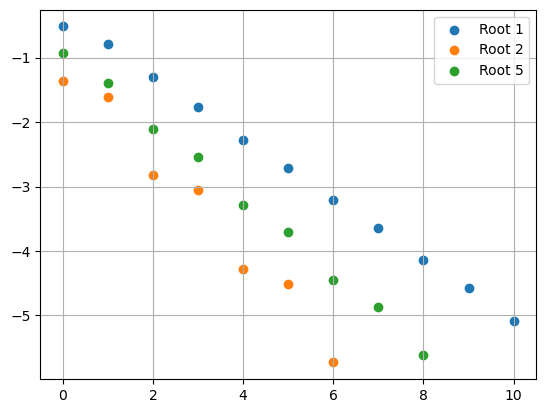

In [11]:
f = lambda x: np.array([
    x[0]**7 - 5 * x[0]**2 * x[1]**4 + 1510,
    x[1]**3 - 3 * x[0]**4 * x[1] - 105,
])

def solve(label, fpi, x0, bl, tr):
    print(80 * "-")
    print(f"Localization: {bl[0]} < x0 = {x0[0]} < {tr[0]}, {bl[1]} < y0 = {x0[1]} < {tr[1]}")
    
    x, diff = solveSystemFpi(fpi, x0, 30, 1e-5, bl, tr)
    print(f"Solution: ({x[0]:.5f}, {x[1]:.5f})")
    
    xref = sp.optimize.fsolve(f, x0)
    print(f"Reference: ({xref[0]:.5f}, {xref[1]:.5f})")
    
    plt.scatter(range(len(diff)), np.log10(diff), label=label)
    plt.grid(True)
    plt.legend()

f_1 = lambda x: np.array([
    ((x[0]**7 + 1510) / (5 * x[1]**4))**(1/2),
    (105 + 3 * x[0]**4 * x[1])**(1/3)
])
solve("Root 1", f_1, [1, 5], [0.5, 4.5], [1.5, 5.5])

f_2 = lambda x: np.array([
    ((x[1]**3 - 105) / (3 * x[1]))**(1/4),
    -((1510 + x[0]**7) / (5 * x[0]**2))**(1/4),
])
solve("Root 2", f_2, [2, -3], [1.5, -3.5], [2.5, -2.5])

# Didn't find converging FPI
# solve(fpi, [-1, 5], [-1.5, 4.5], [-0.5, 5.5])

# Didn't find converging FPI
# solve(fpi, [-3, -0.5], [-3.5, -1], [-2.5, 0])

f_5 = lambda x: np.array([
    -((x[1]**3 - 105) / (3 * x[1]))**(1/4),
    -((1510 + x[0]**7) / (5 * x[0]**2))**(1/4),
])
solve("Root 5", f_5, [ -2, -3], [-2.5, -3.5], [-1.5, -2.5])
